# Problem Statement

Aim of this exercise is to get initial insights of the Wine quality dataset and develop a predictor model using Random Forest classifier.

Random Forest is bagging ensemble method using tree as base learner. It develops many decision trees and trains each tree on one bootstrap sample. Finally the avarage output of all the trees is the output of full ensemble model. Random forest is considered to overfitting proof of developed deeper in size unlike other machine learning algorithms. 

### Methodology
Model development is divided into multiple steps as mentioned below,
- Data exploring and understanding: This step involves preliminary level data understanding and exploring.
- Data Cleaning: This step includes cleaning the existing data. We check the data for any missing values and treat them as per the requirements. We also need to look for constant value colulmns as that is not going to add any additional value to out analysis. Sometimes columns with very high proportion of any particular value also doesn't add any values. Hence, getting rid of them helps with further analysis.
- Data Visualization: This step involves visualizing our dataset and check for relationship amongst independent variables. We can also reduce some feature columns here but it should not be aggressive.
- Data Preparation: This step is mainly usefull for feeding in the data into the model. It involves steps like creating dummy variables, scaling etc. depending upond the data type.
- Train-test split: This step involves spliting the dataset into train and test parts.
- Model Development-validation and evaluaiton: This steps involves training the model and validate it. It involves evaluating the model using relevant matrics.
- Conclusion/Recommendation: It involves drawing conclusions and recommendations to business.

### Importing Dependancies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

### Reading Dataset

In [2]:
data = pd.read_csv('winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Observations,
- Data is having 11 feature columns and one output variable column. It includes total 1599 data entries.
- There aren't any null values in the dataset.
- All the feature columns are float64 types.

## 1. Data Exploration and Understanding

In [4]:
# Splitting into X and y

X = data.drop('quality', axis=1)
y = data['quality']

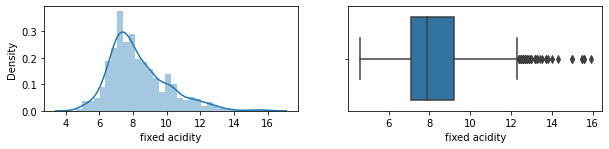

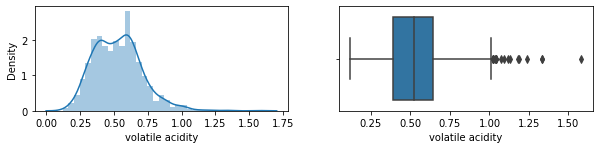

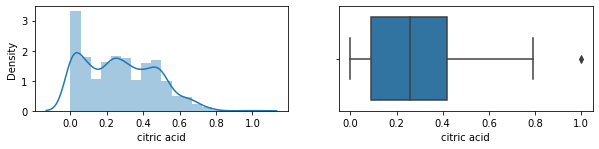

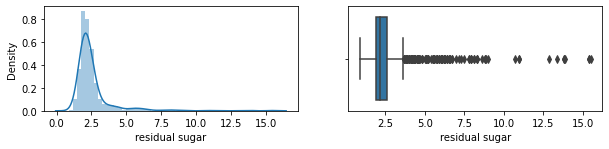

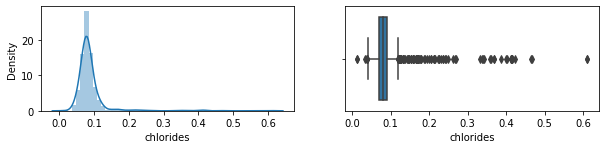

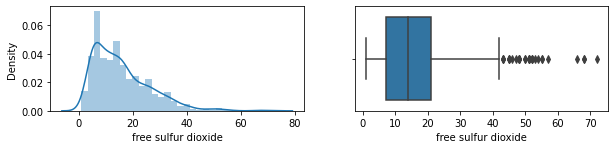

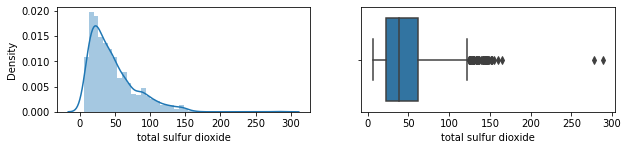

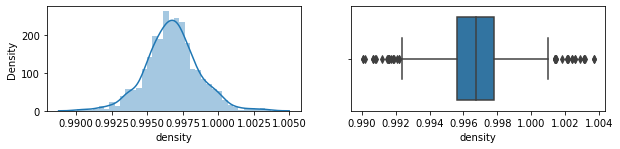

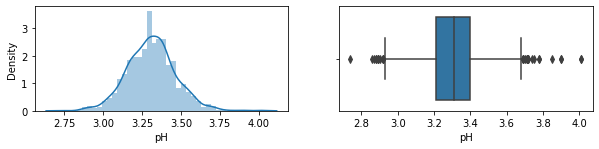

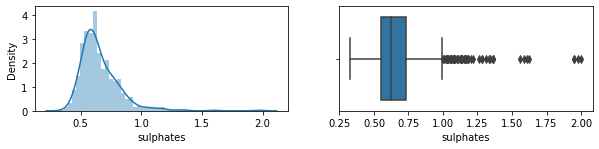

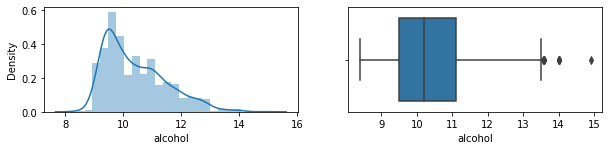

In [5]:
# checking distrubution of each feature (X variables)


for i, feat in enumerate(X.columns):
    plt.subplots(figsize=(10,25))
    plt.subplot(X.shape[1],2,(2*i+1))
    sns.distplot(data[feat])
    plt.subplot(X.shape[1],2,(2*i+2))
    sns.boxplot(data[feat])

Observations,
- 'fixed acidity' is having near normal distribution with median value ~8 units. Soma outliers can be observed.
- 'volatile acidity' is having range from 0 to 1 units and median value ~0.25 units. Soma outliers can be observed.
- 'residual sugar' is having very high number of outlier values. The distribution is concentrated near 0 to 5 and whole range is from 0 to 15.
- 'chlorides' is having very high number of outlier values. The distribution is concentrated near 0 to 0.2 and whole range is from 0 to 0.6.
- 'free sulfur dioxied' is having few outliers with median value of ~40 units.
- 'density' is having normal distribution with median value of 0.007 units.
- 'pH' value is having near normal distribution with median value of 3.3.
- 'sulphates' is having high number of outlier values.
- 'alcohol' is having few outlier but distributed mainly between 8-14.

In [6]:
# checking distrubution of output variable (y)

y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

- Output variable (quality) is having major portion of classes 5, 6, and 7. 
- There are no data entries belong to 1, 2, 9 and 10m

We can use random forest classifier to solve this problem. 

## 2. Data Cleaning

As features columns have many outliers, we are going to drop outliers from the dataset and try to fit the algorithm. For dropping the outliers we are going to use Inter Quantile Range (IQR) method which is summarized below.
- Q1: First quanltile value or Value standing exactly at 10% (here). 
- Q3: Value standing at exactly 90% (here) of the range.
- IQR is difference between Q3 and Q1 value. This indicates the core range for any feature which includes median as well.
- Next is to drop the values which are beyond 1.5 times IQR away from either Q1 or Q3 in respective away direction. Here, away direction for Q1 is lower side and Q3 is upper side.

Note: Here we can use any value for selecting quantiles. The chosen values depend upon the amount of data available and its quality. Also we should not lose significant value of data while dropping outliers.

In [7]:
# Dropping outliers from feature columns

X_cols = data.drop('quality', axis=1).columns
Q1 = data[X_cols].quantile(0.10)
Q3 = data[X_cols].quantile(0.90)
IQR = Q3 - Q1


data = data[~((data[X_cols] < (Q1 - 1.5 * IQR)) |(data[X_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## 3. Data Visualization

<AxesSubplot:>

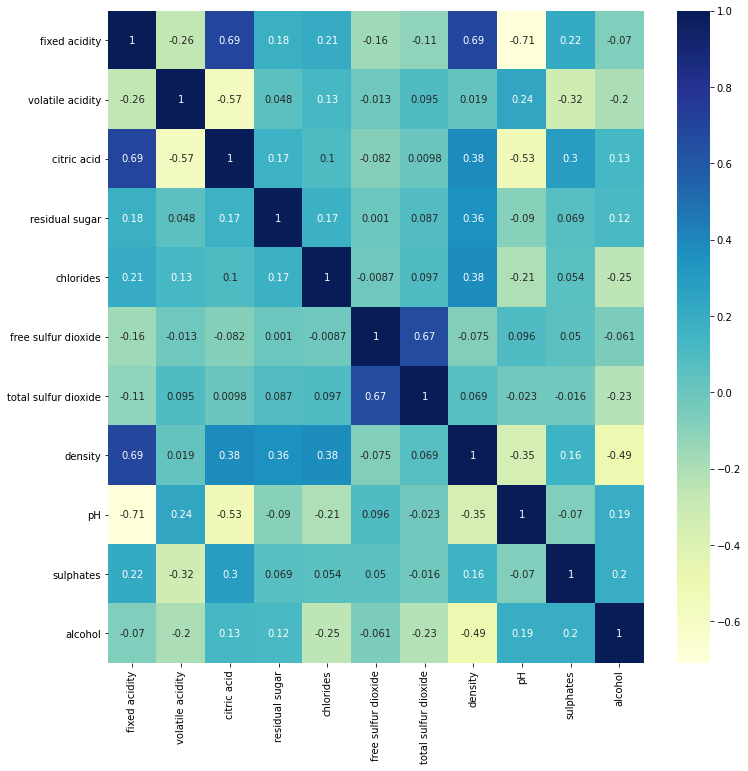

In [8]:
# Pearson's correlation


# heatmap
plt.subplots(figsize=(12,12))
sns.heatmap(data.drop('quality', axis=1).corr(), annot=True, cmap='YlGnBu')

Observation,
- There isn't any strong correlation between numeric feature columns and output variable.
- Some features have negative correlaton amongst them.

## 4. Data Preparation

In [9]:
# class mapping:
# 1-5: Poor --> 0
# 6: Medium --> 1
# 7-10: Good --> 2

y = y.map({1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:2, 8:2, 9:2, 10:2})

In [10]:
# updated y classes

y.value_counts()

0    744
1    638
2    217
Name: quality, dtype: int64

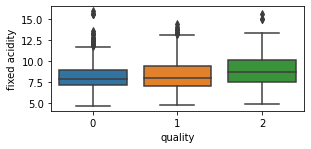

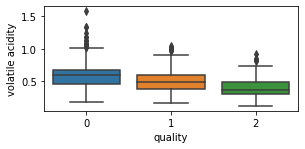

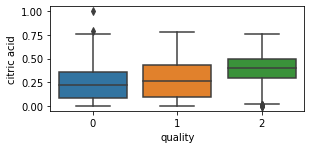

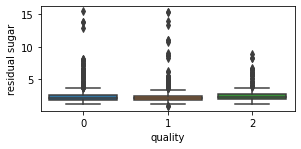

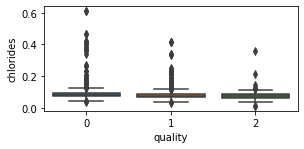

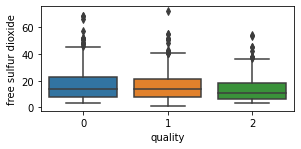

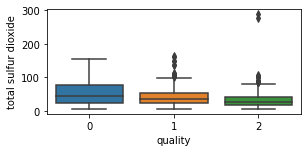

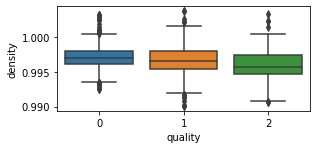

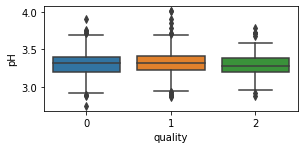

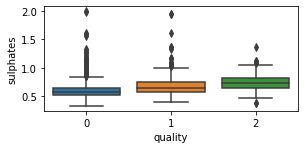

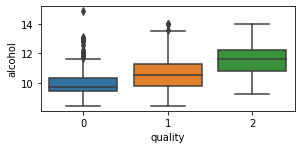

In [11]:
# relationship between features and new y (quality) variable


for i, feat in enumerate(X.columns):
    plt.subplots(figsize=(10,25))
    plt.subplot(X.shape[1], 2, i+1)
    sns.boxplot(y=X[feat], x=y)

We observe there are few features indicating positive or negative relationships with output variable. 


Note:

- We don't require dummy variables as data is in numeric format.
- Tree based models do not require data to be scaled as they are not sensitive to the variance in the data. Hence, we would not any kind of scaling of data. 

## 5. Train-Test split

In [12]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)

## 6. Model Development - Validation and Evaluation

#### Model development using default parameters

In [13]:
# model development

model1 = RandomForestClassifier()

model1.fit(X_train, y_train)

# prediction
y_pred_train1 = model1.predict(X_train)
y_pred_test1 = model1.predict(X_test)

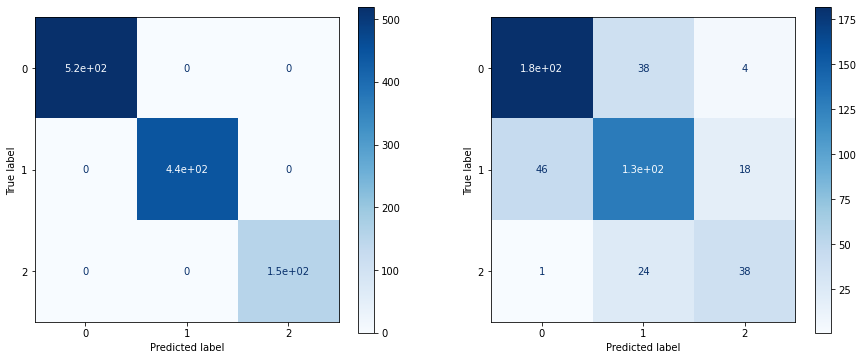

In [14]:
# confusion matrix: train  and test sets

plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1,2,1)
plot_confusion_matrix(model1, X_train, y_train, labels=np.unique(y_train), cmap=plt.cm.Blues, ax=ax1)

ax2 = plt.subplot(1,2,2)
plot_confusion_matrix(model1, X_test, y_test, labels=np.unique(y_test), cmap=plt.cm.Blues, ax=ax2)


In [15]:
# classification report

# train
print(classification_report(y_train, y_pred_train1))

print(' ')

# test
print(classification_report(y_test, y_pred_test1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       1.00      1.00      1.00       445
           2       1.00      1.00      1.00       154

    accuracy                           1.00      1119
   macro avg       1.00      1.00      1.00      1119
weighted avg       1.00      1.00      1.00      1119

 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       224
           1       0.68      0.67      0.67       193
           2       0.63      0.60      0.62        63

    accuracy                           0.73       480
   macro avg       0.70      0.69      0.70       480
weighted avg       0.73      0.73      0.73       480



Observation,

- Model is clearly overfitting to the training dataset. It's performance on test set is significantly lower as compared to train set.

Hence, we would be doing hyper parameter tuning and try to bring train and test accuracy values closer to each other. Since, output variable classes are skewed hence we would be using 'balanced accuracy' as performance measure.

#### Hyper-parameter tuning and model development

Parameters to tune:
- max_dept: maximum allowable depth in the tree. 
- min_samples_split: min number of samples required to split further.
- min_samples_leaf: min number of samples in each leaf.
- n_estimators: number of trees to build.

In [16]:
# parameters grid
params = {'max_depth': np.arange(1, 11, 1),
          'min_samples_leaf': np.arange(10, 60, 5),
          'min_samples_split': np.arange(15, 100, 5),
          'n_estimators': [50, 75, 100, 125, 150, 200, 250, 500]}

model2 = RandomForestClassifier()

# cross validation
folds=5 

model_cv = RandomizedSearchCV(estimator = model2, 
                            param_distributions = params,
                            n_iter = 500,
                            scoring= 'balanced_accuracy',
                            n_jobs = -1,
                            cv = folds, 
                            return_train_score=True,
                            verbose = 1,
                            random_state = 42)    


model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 10.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [17]:
# Best hyper parameter value after randomsearch
print(model_cv.best_params_)

{'n_estimators': 100, 'min_samples_split': 25, 'min_samples_leaf': 10, 'max_depth': 7}


In [18]:
# Checking performance variation with parameter value

cv_res = pd.DataFrame(model_cv.cv_results_)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.521959,0.147135,0.162758,0.028873,500,70,55,8,"{'n_estimators': 500, 'min_samples_split': 70,...",0.541153,...,0.482139,0.041937,371,0.545450,0.507590,0.527632,0.497246,0.529852,0.521554,0.017104
1,0.372020,0.029111,0.023154,0.004447,75,50,30,5,"{'n_estimators': 75, 'min_samples_split': 50, ...",0.547620,...,0.536006,0.053203,90,0.609743,0.585803,0.589602,0.587973,0.603978,0.595420,0.009594
2,1.447447,0.061267,0.107326,0.035459,250,90,10,5,"{'n_estimators': 250, 'min_samples_split': 90,...",0.537465,...,0.509547,0.041709,232,0.609176,0.583660,0.595175,0.560837,0.587700,0.587309,0.015839
3,1.130786,0.131095,0.092958,0.022525,250,75,10,1,"{'n_estimators': 250, 'min_samples_split': 75,...",0.457505,...,0.437633,0.028329,481,0.437581,0.448025,0.465689,0.459135,0.462349,0.454556,0.010358
4,3.058260,0.171531,0.155762,0.058519,500,75,20,5,"{'n_estimators': 500, 'min_samples_split': 75,...",0.547677,...,0.531455,0.047288,117,0.619611,0.593194,0.598092,0.588738,0.598028,0.599533,0.010622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.371465,0.028671,0.020429,0.002321,75,75,30,6,"{'n_estimators': 75, 'min_samples_split': 75, ...",0.552446,...,0.528238,0.049365,134,0.579527,0.574566,0.592807,0.594293,0.595368,0.587313,0.008566
496,0.815140,0.034837,0.049198,0.003599,200,55,25,9,"{'n_estimators': 200, 'min_samples_split': 55,...",0.562659,...,0.539148,0.050884,74,0.638635,0.625237,0.607149,0.604917,0.625995,0.620387,0.012669
497,1.853912,0.013353,0.117192,0.009809,500,80,50,9,"{'n_estimators': 500, 'min_samples_split': 80,...",0.548644,...,0.496216,0.051839,317,0.548259,0.529234,0.547709,0.535780,0.540059,0.540208,0.007227
498,0.172657,0.005702,0.014295,0.000566,50,80,55,1,"{'n_estimators': 50, 'min_samples_split': 80, ...",0.445729,...,0.433672,0.019983,491,0.431954,0.444162,0.454318,0.439706,0.464086,0.446845,0.011252


In [19]:
# model development using best features

model3 = RandomForestClassifier(max_depth = model_cv.best_params_['max_depth'],
                                min_samples_leaf = model_cv.best_params_['min_samples_leaf'],
                                min_samples_split = model_cv.best_params_['min_samples_split'],
                                n_estimators = model_cv.best_params_['n_estimators'])

# fit
model3.fit(X_train, y_train) 

# prediction
y_pred_train3 = model3.predict(X_train)
y_pred_test3 = model3.predict(X_test)

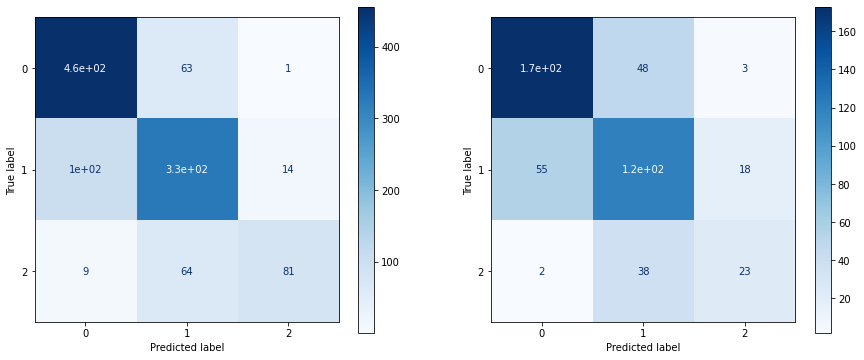

In [20]:
# confusion matrix: train  and test sets

plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1,2,1)
plot_confusion_matrix(model3, X_train, y_train, labels=np.unique(y_train), cmap=plt.cm.Blues, ax=ax1)

ax2 = plt.subplot(1,2,2)
plot_confusion_matrix(model3, X_test, y_test, labels=np.unique(y_test), cmap=plt.cm.Blues, ax=ax2)

In [21]:
# classification report

# train
print(classification_report(y_train, y_pred_train3))

print(' ')

# test
print(classification_report(y_test, y_pred_test3))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       520
           1       0.72      0.73      0.73       445
           2       0.84      0.53      0.65       154

    accuracy                           0.77      1119
   macro avg       0.79      0.71      0.74      1119
weighted avg       0.77      0.77      0.77      1119

 
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       224
           1       0.58      0.62      0.60       193
           2       0.52      0.37      0.43        63

    accuracy                           0.66       480
   macro avg       0.62      0.59      0.60       480
weighted avg       0.65      0.66      0.65       480



Observations,
- Train and test accuracy values are near to each other as compared to first iteration. Hence model is less overfitting.
- Here we would be considering weighted values for precision, recall and f1 score since the dataset is skewed. The corresponding values are near 0.66 or above in both train and test cases.

## 7. Conclusion

- Random Forest algorithm is resulting in the ~0.66 accuracy on Wine quality dataset which is not so good performance.
- Precision-recall and f1 score values are near to 0.66.
- We can extend the hyperparameter tuning space and improve the performance but that requires extensive computational capabilities and time. Hence, we are limiting it upto this point for demonstation purpose.

-------